In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_no_lagrange, test_loop
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [4]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=0)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=2048 * 8)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=80)
parser.add_argument('--batch-size', type=int, default=128 * 32)
parser.add_argument('--test-batch-size', type=int, default=4096)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1.0)
parser.add_argument('--rho-incr-iter', type=int, default=2)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=30)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=5e-2)
parser.add_argument('--sinkhorn-rounds', type=int, default=10)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=4096, lagr_update_iter=30, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=80, num_examples=524288, random_seed=0, rgt_start=0, rho=1.0, rho_incr_amount=1.0, rho_incr_iter=2, sinkhorn_epsilon=0.05, sinkhorn_rounds=10, test_batch_size=4096, test_iter=5, test_misreport_iter=2000, test_num_examples=16384)

In [5]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = ds.preset_valuation_range(args.n_agents, args.n_items, dataset_name)

model = DoubleNet(
    args.n_agents, args.n_items, item_ranges, args.sinkhorn_epsilon, args.sinkhorn_rounds, marginal_choice='additive'
).to(device)

train_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.num_examples, item_ranges).to(device)
train_loader = ds.Dataloader(train_data, batch_size=args.batch_size, shuffle=True)

In [6]:
%%time
train_loop(model, train_loader, args, device=device)

  1%|▏         | 1/80 [00:36<47:40, 36.21s/it]

{'regret_max': 0.5529031753540039, 'regret_mean': 0.014120207168161869, 'regret_,ults': tensor([[5.8699]], device='cuda:0'), 'payment': 0.4618889391422272}


  2%|▎         | 2/80 [01:11<46:47, 35.99s/it]

{'regret_max': 0.07803407311439514, 'regret_mean': 0.005194738507270813, 'regret_,ults': tensor([[7.5627]], device='cuda:0'), 'payment': 0.5432776212692261}


  4%|▍         | 3/80 [01:47<46:08, 35.95s/it]

{'regret_max': 0.05131959915161133, 'regret_mean': 0.004044273868203163, 'regret_,ults': tensor([[9.9265]], device='cuda:0'), 'payment': 0.5428130626678467}


  5%|▌         | 4/80 [02:23<45:40, 36.05s/it]

{'regret_max': 0.05640590190887451, 'regret_mean': 0.0031839674338698387, 'regret_,ults': tensor([[13.0981]], device='cuda:0'), 'payment': 0.5388477444648743}


  6%|▋         | 5/80 [02:59<44:51, 35.89s/it]

{'regret_max': 0.03829169273376465, 'regret_mean': 0.002469949424266815, 'regret_,ults': tensor([[16.2401]], device='cuda:0'), 'payment': 0.5342361330986023}


  8%|▊         | 6/80 [03:34<44:06, 35.77s/it]

{'regret_max': 0.048864126205444336, 'regret_mean': 0.0019422867335379124, 'regret_,ults': tensor([[18.4995]], device='cuda:0'), 'payment': 0.5313857793807983}


  9%|▉         | 7/80 [04:10<43:29, 35.75s/it]

{'regret_max': 0.03607207536697388, 'regret_mean': 0.0020135275553911924, 'regret_,ults': tensor([[20.8599]], device='cuda:0'), 'payment': 0.5294225811958313}


 10%|█         | 8/80 [04:45<42:41, 35.58s/it]

{'regret_max': 0.023743867874145508, 'regret_mean': 0.0014743705978617072, 'regret_,ults': tensor([[25.1705]], device='cuda:0'), 'payment': 0.5280948877334595}


 11%|█▏        | 9/80 [05:21<42:16, 35.72s/it]

{'regret_max': 0.018593549728393555, 'regret_mean': 0.0012086040806025267, 'regret_,ults': tensor([[27.8857]], device='cuda:0'), 'payment': 0.5287677049636841}


 12%|█▎        | 10/80 [05:57<41:39, 35.70s/it]

{'regret_max': 0.018064260482788086, 'regret_mean': 0.001185651053674519, 'regret_,ults': tensor([[29.8185]], device='cuda:0'), 'payment': 0.5279446840286255}


 14%|█▍        | 11/80 [06:32<40:57, 35.61s/it]

{'regret_max': 0.0167236328125, 'regret_mean': 0.0009802094427868724, 'regret_,ults': tensor([[33.0619]], device='cuda:0'), 'payment': 0.52926105260849}


 15%|█▌        | 12/80 [07:08<40:12, 35.48s/it]

{'regret_max': 0.016022324562072754, 'regret_mean': 0.0007752997917123139, 'regret_,ults': tensor([[35.6168]], device='cuda:0'), 'payment': 0.5292091369628906}


 16%|█▋        | 13/80 [07:43<39:37, 35.48s/it]

{'regret_max': 0.011065363883972168, 'regret_mean': 0.0006351876072585583, 'regret_,ults': tensor([[37.1481]], device='cuda:0'), 'payment': 0.5301740765571594}


 18%|█▊        | 14/80 [08:18<38:56, 35.41s/it]

{'regret_max': 0.011232435703277588, 'regret_mean': 0.0006310881581157446, 'regret_,ults': tensor([[39.2733]], device='cuda:0'), 'payment': 0.5302718877792358}


 19%|█▉        | 15/80 [08:54<38:21, 35.40s/it]

{'regret_max': 0.012389063835144043, 'regret_mean': 0.0005821480299346149, 'regret_,ults': tensor([[42.2916]], device='cuda:0'), 'payment': 0.5325024127960205}


 20%|██        | 16/80 [09:29<37:45, 35.40s/it]

{'regret_max': 0.010187506675720215, 'regret_mean': 0.0004963892861269414, 'regret_,ults': tensor([[43.7568]], device='cuda:0'), 'payment': 0.5321387052536011}


 21%|██▏       | 17/80 [10:04<37:09, 35.38s/it]

{'regret_max': 0.009659051895141602, 'regret_mean': 0.0005149388452991843, 'regret_,ults': tensor([[45.2105]], device='cuda:0'), 'payment': 0.5306624174118042}


 22%|██▎       | 18/80 [10:40<36:38, 35.46s/it]

{'regret_max': 0.011746466159820557, 'regret_mean': 0.00043608949636109173, 'regret_,ults': tensor([[46.7429]], device='cuda:0'), 'payment': 0.5318915843963623}


 24%|██▍       | 19/80 [11:15<35:55, 35.34s/it]

{'regret_max': 0.00872504711151123, 'regret_mean': 0.0003844789753202349, 'regret_,ults': tensor([[48.5848]], device='cuda:0'), 'payment': 0.5325602293014526}


 25%|██▌       | 20/80 [11:50<35:21, 35.37s/it]

{'regret_max': 0.009974062442779541, 'regret_mean': 0.0003734719648491591, 'regret_,ults': tensor([[50.4545]], device='cuda:0'), 'payment': 0.5324583053588867}


 26%|██▋       | 21/80 [12:26<34:57, 35.55s/it]

{'regret_max': 0.010802984237670898, 'regret_mean': 0.00036000300315208733, 'regret_,ults': tensor([[53.6358]], device='cuda:0'), 'payment': 0.5307590961456299}


 28%|██▊       | 22/80 [13:02<34:19, 35.51s/it]

{'regret_max': 0.010015726089477539, 'regret_mean': 0.000380659505026415, 'regret_,ults': tensor([[55.5770]], device='cuda:0'), 'payment': 0.5311190485954285}


 29%|██▉       | 23/80 [13:37<33:38, 35.42s/it]

{'regret_max': 0.00793534517288208, 'regret_mean': 0.0002894990611821413, 'regret_,ults': tensor([[57.4140]], device='cuda:0'), 'payment': 0.5336016416549683}


 30%|███       | 24/80 [14:12<33:01, 35.38s/it]

{'regret_max': 0.009882509708404541, 'regret_mean': 0.000351987371686846, 'regret_,ults': tensor([[58.7234]], device='cuda:0'), 'payment': 0.5329045057296753}


 31%|███▏      | 25/80 [14:48<32:21, 35.31s/it]

{'regret_max': 0.009506940841674805, 'regret_mean': 0.0003395895182620734, 'regret_,ults': tensor([[60.3511]], device='cuda:0'), 'payment': 0.5335543751716614}


 32%|███▎      | 26/80 [15:23<31:51, 35.40s/it]

{'regret_max': 0.009193956851959229, 'regret_mean': 0.0002904958091676235, 'regret_,ults': tensor([[61.4697]], device='cuda:0'), 'payment': 0.5339443683624268}


 34%|███▍      | 27/80 [15:59<31:17, 35.42s/it]

{'regret_max': 0.009445250034332275, 'regret_mean': 0.00026163848815485835, 'regret_,ults': tensor([[63.9818]], device='cuda:0'), 'payment': 0.5344236493110657}


 35%|███▌      | 28/80 [16:34<30:34, 35.28s/it]

{'regret_max': 0.010728240013122559, 'regret_mean': 0.0002751254360191524, 'regret_,ults': tensor([[66.9802]], device='cuda:0'), 'payment': 0.5345418453216553}


 36%|███▋      | 29/80 [17:09<29:58, 35.26s/it]

{'regret_max': 0.010023713111877441, 'regret_mean': 0.00028177376952953637, 'regret_,ults': tensor([[69.0162]], device='cuda:0'), 'payment': 0.5336803793907166}


 38%|███▊      | 30/80 [17:44<29:27, 35.35s/it]

{'regret_max': 0.009147465229034424, 'regret_mean': 0.00025545511743985116, 'regret_,ults': tensor([[71.6155]], device='cuda:0'), 'payment': 0.5350079536437988}


 39%|███▉      | 31/80 [18:19<28:48, 35.27s/it]

{'regret_max': 0.008435487747192383, 'regret_mean': 0.00028331828070804477, 'regret_,ults': tensor([[74.5607]], device='cuda:0'), 'payment': 0.5357389450073242}


 40%|████      | 32/80 [18:54<28:07, 35.16s/it]

{'regret_max': 0.010226845741271973, 'regret_mean': 0.0002884517307393253, 'regret_,ults': tensor([[76.6145]], device='cuda:0'), 'payment': 0.5336875319480896}


 41%|████▏     | 33/80 [19:29<27:28, 35.08s/it]

{'regret_max': 0.008559167385101318, 'regret_mean': 0.00022030092077329755, 'regret_,ults': tensor([[78.3042]], device='cuda:0'), 'payment': 0.5357166528701782}


 42%|████▎     | 34/80 [20:04<26:48, 34.98s/it]

{'regret_max': 0.009626388549804688, 'regret_mean': 0.0002646208449732512, 'regret_,ults': tensor([[80.1957]], device='cuda:0'), 'payment': 0.5331249237060547}


 44%|████▍     | 35/80 [20:39<26:18, 35.07s/it]

{'regret_max': 0.009503662586212158, 'regret_mean': 0.0002176749549107626, 'regret_,ults': tensor([[82.3901]], device='cuda:0'), 'payment': 0.5364992618560791}


 45%|████▌     | 36/80 [21:14<25:45, 35.12s/it]

{'regret_max': 0.009728968143463135, 'regret_mean': 0.00023473519831895828, 'regret_,ults': tensor([[84.2750]], device='cuda:0'), 'payment': 0.5353432893753052}


 46%|████▋     | 37/80 [21:49<25:06, 35.04s/it]

{'regret_max': 0.009067535400390625, 'regret_mean': 0.00022681080736219883, 'regret_,ults': tensor([[86.7577]], device='cuda:0'), 'payment': 0.5353418588638306}


 48%|████▊     | 38/80 [22:25<24:38, 35.20s/it]

{'regret_max': 0.00964432954788208, 'regret_mean': 0.00019567561685107648, 'regret_,ults': tensor([[88.8793]], device='cuda:0'), 'payment': 0.5359991788864136}


 49%|████▉     | 39/80 [23:00<23:59, 35.10s/it]

{'regret_max': 0.0122605562210083, 'regret_mean': 0.00023134530056267977, 'regret_,ults': tensor([[91.2349]], device='cuda:0'), 'payment': 0.5343466997146606}


 50%|█████     | 40/80 [23:35<23:20, 35.02s/it]

{'regret_max': 0.012278437614440918, 'regret_mean': 0.00021117946016602218, 'regret_,ults': tensor([[94.2965]], device='cuda:0'), 'payment': 0.5342555642127991}


 51%|█████▏    | 41/80 [24:10<22:47, 35.08s/it]

{'regret_max': 0.010915100574493408, 'regret_mean': 0.0002317358594154939, 'regret_,ults': tensor([[96.9612]], device='cuda:0'), 'payment': 0.5339165329933167}


 52%|█████▎    | 42/80 [24:44<22:08, 34.97s/it]

{'regret_max': 0.011359035968780518, 'regret_mean': 0.00015781589900143445, 'regret_,ults': tensor([[99.0172]], device='cuda:0'), 'payment': 0.5358151197433472}


 54%|█████▍    | 43/80 [25:20<21:34, 34.99s/it]

{'regret_max': 0.00930088758468628, 'regret_mean': 0.00021270086290314794, 'regret_,ults': tensor([[100.8066]], device='cuda:0'), 'payment': 0.5337192416191101}


 55%|█████▌    | 44/80 [25:54<20:59, 34.97s/it]

{'regret_max': 0.010062575340270996, 'regret_mean': 0.00018133549019694328, 'regret_,ults': tensor([[102.4824]], device='cuda:0'), 'payment': 0.5346373319625854}


 56%|█████▋    | 45/80 [26:29<20:22, 34.94s/it]

{'regret_max': 0.011860132217407227, 'regret_mean': 0.00021954672411084175, 'regret_,ults': tensor([[106.8860]], device='cuda:0'), 'payment': 0.5339328050613403}


 57%|█████▊    | 46/80 [27:04<19:46, 34.91s/it]

{'regret_max': 0.008768618106842041, 'regret_mean': 0.00022184701811056584, 'regret_,ults': tensor([[110.1030]], device='cuda:0'), 'payment': 0.5330172181129456}


 59%|█████▉    | 47/80 [27:39<19:10, 34.87s/it]

{'regret_max': 0.008788526058197021, 'regret_mean': 0.00016628198500256985, 'regret_,ults': tensor([[112.0672]], device='cuda:0'), 'payment': 0.5330873727798462}


 60%|██████    | 48/80 [28:14<18:35, 34.87s/it]

{'regret_max': 0.008143186569213867, 'regret_mean': 0.00015857096877880394, 'regret_,ults': tensor([[114.3111]], device='cuda:0'), 'payment': 0.5344979763031006}


 61%|██████▏   | 49/80 [28:50<18:08, 35.12s/it]

{'regret_max': 0.00844728946685791, 'regret_mean': 0.00014106265734881163, 'regret_,ults': tensor([[116.9149]], device='cuda:0'), 'payment': 0.5346194505691528}


 62%|██████▎   | 50/80 [29:25<17:36, 35.21s/it]

{'regret_max': 0.01055079698562622, 'regret_mean': 0.00018525455379858613, 'regret_,ults': tensor([[118.3460]], device='cuda:0'), 'payment': 0.5326031446456909}


 64%|██████▍   | 51/80 [30:00<16:58, 35.13s/it]

{'regret_max': 0.008769810199737549, 'regret_mean': 0.00013549032155424356, 'regret_,ults': tensor([[121.3262]], device='cuda:0'), 'payment': 0.5344223380088806}


 65%|██████▌   | 52/80 [30:35<16:23, 35.14s/it]

{'regret_max': 0.00794374942779541, 'regret_mean': 0.00020537566160783172, 'regret_,ults': tensor([[124.9165]], device='cuda:0'), 'payment': 0.5321763753890991}


 66%|██████▋   | 53/80 [31:10<15:49, 35.18s/it]

{'regret_max': 0.008688926696777344, 'regret_mean': 0.00017146441678050905, 'regret_,ults': tensor([[128.1344]], device='cuda:0'), 'payment': 0.5308710336685181}


 68%|██████▊   | 54/80 [31:45<15:09, 34.97s/it]

{'regret_max': 0.00772404670715332, 'regret_mean': 0.00011937748786294833, 'regret_,ults': tensor([[130.4543]], device='cuda:0'), 'payment': 0.533206582069397}


 69%|██████▉   | 55/80 [32:19<14:32, 34.89s/it]

{'regret_max': 0.008421003818511963, 'regret_mean': 0.00012022599548799917, 'regret_,ults': tensor([[131.7058]], device='cuda:0'), 'payment': 0.5347685813903809}


 70%|███████   | 56/80 [32:54<13:55, 34.82s/it]

{'regret_max': 0.010308265686035156, 'regret_mean': 0.00017203651077579707, 'regret_,ults': tensor([[134.1245]], device='cuda:0'), 'payment': 0.5318043828010559}


 71%|███████▏  | 57/80 [33:29<13:17, 34.68s/it]

{'regret_max': 0.007637441158294678, 'regret_mean': 0.00013774982653558254, 'regret_,ults': tensor([[135.6615]], device='cuda:0'), 'payment': 0.5332939028739929}


 72%|███████▎  | 58/80 [34:03<12:41, 34.60s/it]

{'regret_max': 0.00919044017791748, 'regret_mean': 0.00013039204350207, 'regret_,ults': tensor([[137.2007]], device='cuda:0'), 'payment': 0.532591700553894}


 74%|███████▍  | 59/80 [34:37<12:04, 34.49s/it]

{'regret_max': 0.008532941341400146, 'regret_mean': 0.00011584216554183513, 'regret_,ults': tensor([[138.5644]], device='cuda:0'), 'payment': 0.5340332388877869}


 75%|███████▌  | 60/80 [35:12<11:30, 34.51s/it]

{'regret_max': 0.008401572704315186, 'regret_mean': 0.00011322293721605092, 'regret_,ults': tensor([[140.0605]], device='cuda:0'), 'payment': 0.5339240431785583}


 76%|███████▋  | 61/80 [35:46<10:56, 34.54s/it]

{'regret_max': 0.008299529552459717, 'regret_mean': 0.00013612318434752524, 'regret_,ults': tensor([[143.6735]], device='cuda:0'), 'payment': 0.5321854948997498}


 78%|███████▊  | 62/80 [36:21<10:22, 34.58s/it]

{'regret_max': 0.007546186447143555, 'regret_mean': 0.00013968005077913404, 'regret_,ults': tensor([[145.4725]], device='cuda:0'), 'payment': 0.531889021396637}


 79%|███████▉  | 63/80 [36:56<09:48, 34.60s/it]

{'regret_max': 0.006594836711883545, 'regret_mean': 0.00011884542618645355, 'regret_,ults': tensor([[146.6716]], device='cuda:0'), 'payment': 0.5333112478256226}


 80%|████████  | 64/80 [37:30<09:12, 34.50s/it]

{'regret_max': 0.007625281810760498, 'regret_mean': 0.00013028996181674302, 'regret_,ults': tensor([[149.3451]], device='cuda:0'), 'payment': 0.5309416055679321}


 81%|████████▏ | 65/80 [38:04<08:36, 34.44s/it]

{'regret_max': 0.008306145668029785, 'regret_mean': 0.000128746876725927, 'regret_,ults': tensor([[151.2300]], device='cuda:0'), 'payment': 0.532799482345581}


 82%|████████▎ | 66/80 [38:39<08:02, 34.44s/it]

{'regret_max': 0.011024415493011475, 'regret_mean': 0.00015645587700419128, 'regret_,ults': tensor([[155.7309]], device='cuda:0'), 'payment': 0.5303645133972168}


 84%|████████▍ | 67/80 [39:13<07:26, 34.38s/it]

{'regret_max': 0.012826323509216309, 'regret_mean': 0.00015479449939448386, 'regret_,ults': tensor([[157.6509]], device='cuda:0'), 'payment': 0.5306333303451538}


 85%|████████▌ | 68/80 [39:47<06:51, 34.32s/it]

{'regret_max': 0.00681757926940918, 'regret_mean': 0.00010111671872437, 'regret_,ults': tensor([[159.4534]], device='cuda:0'), 'payment': 0.5318573713302612}


 86%|████████▋ | 69/80 [40:22<06:17, 34.36s/it]

{'regret_max': 0.09840917587280273, 'regret_mean': 0.0011783961672335863, 'regret_,ults': tensor([[167.2567]], device='cuda:0'), 'payment': 0.5277252197265625}


 88%|████████▊ | 70/80 [40:56<05:43, 34.31s/it]

{'regret_max': 0.006951391696929932, 'regret_mean': 7.071338768582791e-05, 'regret_,ults': tensor([[168.3099]], device='cuda:0'), 'payment': 0.529782772064209}


 89%|████████▉ | 71/80 [41:30<05:08, 34.28s/it]

{'regret_max': 0.0061528682708740234, 'regret_mean': 9.273974865209311e-05, 'regret_,ults': tensor([[170.5328]], device='cuda:0'), 'payment': 0.530890703201294}


 90%|█████████ | 72/80 [42:04<04:34, 34.32s/it]

{'regret_max': 0.008728325366973877, 'regret_mean': 0.00012146266817580909, 'regret_,ults': tensor([[173.9193]], device='cuda:0'), 'payment': 0.5308980941772461}


 91%|█████████▏| 73/80 [42:39<04:00, 34.32s/it]

{'regret_max': 0.007980525493621826, 'regret_mean': 6.496464629890397e-05, 'regret_,ults': tensor([[174.8747]], device='cuda:0'), 'payment': 0.5340282917022705}


 92%|█████████▎| 74/80 [43:13<03:26, 34.35s/it]

{'regret_max': 0.008266091346740723, 'regret_mean': 0.00010583236871752888, 'regret_,ults': tensor([[176.0343]], device='cuda:0'), 'payment': 0.5312650799751282}


 94%|█████████▍| 75/80 [43:48<02:52, 34.43s/it]

{'regret_max': 0.008152425289154053, 'regret_mean': 9.580389451002702e-05, 'regret_,ults': tensor([[178.1989]], device='cuda:0'), 'payment': 0.5339574813842773}


 95%|█████████▌| 76/80 [44:22<02:17, 34.44s/it]

{'regret_max': 0.007105469703674316, 'regret_mean': 9.486335329711437e-05, 'regret_,ults': tensor([[179.7773]], device='cuda:0'), 'payment': 0.5314364433288574}


 96%|█████████▋| 77/80 [44:56<01:42, 34.30s/it]

{'regret_max': 0.007752478122711182, 'regret_mean': 7.598083175253123e-05, 'regret_,ults': tensor([[180.8829]], device='cuda:0'), 'payment': 0.531731128692627}


 98%|█████████▊| 78/80 [45:30<01:08, 34.30s/it]

{'regret_max': 0.012428820133209229, 'regret_mean': 0.00011271261610090733, 'regret_,ults': tensor([[182.3803]], device='cuda:0'), 'payment': 0.531445324420929}


 99%|█████████▉| 79/80 [46:06<00:34, 34.56s/it]

{'regret_max': 0.007569730281829834, 'regret_mean': 7.040906348265707e-05, 'regret_,ults': tensor([[184.6765]], device='cuda:0'), 'payment': 0.5327785015106201}


100%|██████████| 80/80 [46:40<00:00, 35.01s/it]

{'regret_max': 0.008003652095794678, 'regret_mean': 9.395989764016122e-05, 'regret_,ults': tensor([[186.2366]], device='cuda:0'), 'payment': 0.5300977826118469}
CPU times: user 46min 27s, sys: 9.23 s, total: 46min 36s
Wall time: 46min 40s


In [7]:
%%time
test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

CPU times: user 1min 18s, sys: 240 ms, total: 1min 19s
Wall time: 1min 19s


{'payment_mean': 0.5275906920433044,
 'regret_mean': 0.0009520766325294971,
 'regret_max': 0.006192505359649658}

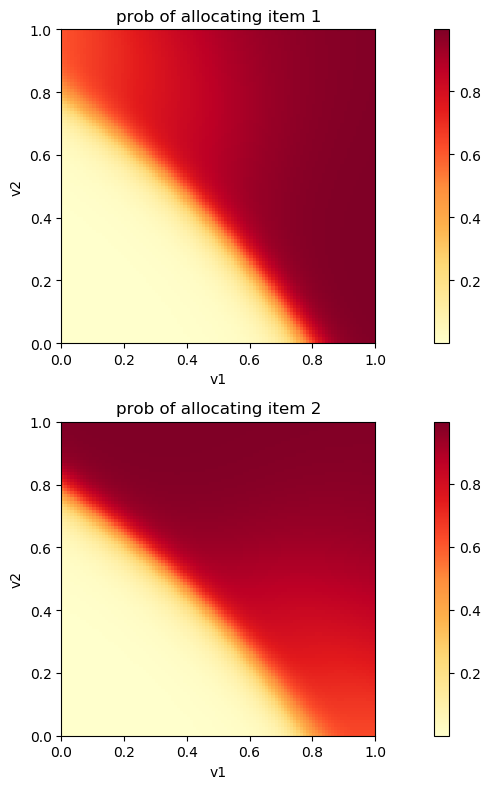

In [8]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
model.sinkhorn_rounds = 100
model.sinkhorn_epsilon = 5e-2
pu.plot_12_model(model.to(device='cpu'), 0.01, (0,1), (0,1))

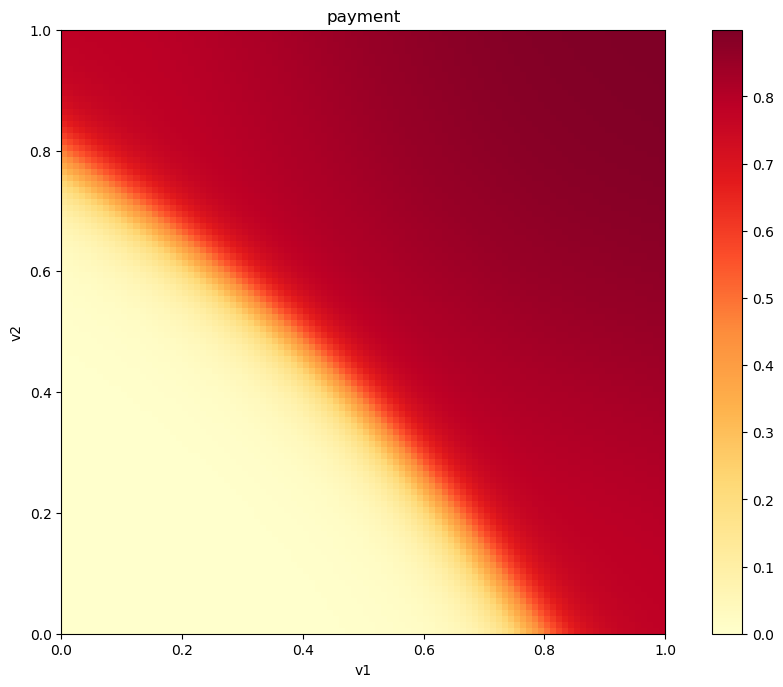

In [9]:
def plot_12_model_payments(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_payments = output_payments.view(xlen, ylen)
    f, (ax1) = plt.subplots(1, 1)
    im1 = ax1.imshow(output_item1_payments.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1])
    ax1.set_title('payment')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    f.colorbar(im1)
    f.show()
    
plot_12_model_payments(model.to(device='cpu'), 0.01, (0,1), (0,1))

In [10]:
def additive_1x2_0_1_optimal_mechanism(bids):
    import math
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((bids.shape[0], bids.shape[1]))
    for i in range(bids.shape[0]):
        if bids[i, :, 0] > (2 / 3) and bids[i, :, 1] < (2 - math.sqrt(2)) / 3:
            allocs[i, 0, :] = torch.tensor([1, 0])
            payments[i, :] = 2 / 3
        elif bids[i, :, 1] > (2 / 3) and bids[i, :, 0] < (2 - math.sqrt(2)) / 3:
            allocs[i, 0, :] = torch.tensor([0, 1])
            payments[i, :] = 2 / 3
        elif (2 - math.sqrt(2)) / 3 - bids[i, :, 0] < bids[i, 0, 1] - 2 / 3:
            allocs[i, 0, :] = torch.tensor([1, 1])
            payments[i, :] = 4 / 3 - math.sqrt(2) / 3
    return allocs, payments

In [11]:
import double_net.utils_misreport as utils
allocs, payments = additive_1x2_0_1_optimal_mechanism(test_data)

In [12]:
utils = utils.calc_agent_util(test_data, allocs.to(device=device), payments.to(device=device))

In [13]:
payments.mean()

tensor(0.5413)

In [14]:
model(torch.tensor([[[.0, .9]]]))

(tensor([[[0.5990, 0.9623]]], grad_fn=<ViewBackward>),
 tensor([[0.7494]], grad_fn=<MulBackward0>))